## Loading of Stringer orientations data

includes some visualizations

In [2]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [142]:
dat['info']

'responses of 23589 neurons to 4598 static gratings'

## Mind readers analysis - LDA

In [ ]:
#@title Mind readers analysis - LDA

![alt text](https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png)

See: [Linear Discriminant Analysis](https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png)

In [5]:
#@title Classification with Linear discriminant analysis for orientation in V1
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import sklearn.model_selection
import scipy.stats

train_size = 0.7 #use 70% of the data for training
rng = np.random.RandomState(0) #define random number generator

clf = LDA() #define LDA

n = 10 #number of categories to distingush
spanistim = 2 * np.pi / n 
labelsistim = dat["istim"] // spanistim # splits the data in n categories (whole numbers)
sresp = dat['sresp'].T #read out the neuronal activity for each neuron

print(np.unique(labelsistim)) #show the labels





[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [6]:
#Split the data into test and training sets
X_trainistim, X_testistim, y_trainistim, y_testistim = sklearn.model_selection.train_test_split(dat['sresp'].T, labelsistim, train_size=train_size, random_state=rng)
#Calculate z-score to make neuronal activity comparable
Z_trainistim = scipy.stats.zscore(X_trainistim, axis=1)
Z_testistim = scipy.stats.zscore(X_testistim, axis=1)

In [ ]:
clf.fit(Z_trainistim, y_trainistim)
#LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
#  store_covariance=False, tol=0.0001) #used inputs for LDA()

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
y_predistim = clf.predict(Z_testistim) #Predict classes for test set

#plt.scatter(y_test, y_pred) #Scatter plot between real and predicted input

In [ ]:
#Plot predictions vs. real class as confusion matrix
from sklearn.metrics import confusion_matrix
confistim = confusion_matrix(y_testistim, y_predistim)
print(confistim)

[[112   3   0   0   0   0   0   0   0   2]
 [  4 137   4   0   0   0   0   0   0   0]
 [  0   4 136   0   0   0   0   0   0   0]
 [  0   0   4 143   0   0   0   0   0   1]
 [  0   0   0   3 126   3   0   0   0   1]
 [  2   0   0   0   4 136   3   0   0   0]
 [  0   1   0   0   0   4 131   1   0   0]
 [  0   0   0   0   0   0   1 132   5   0]
 [  0   0   0   0   0   0   0   3 124   8]
 [  5   0   0   0   1   0   0   0   3 133]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


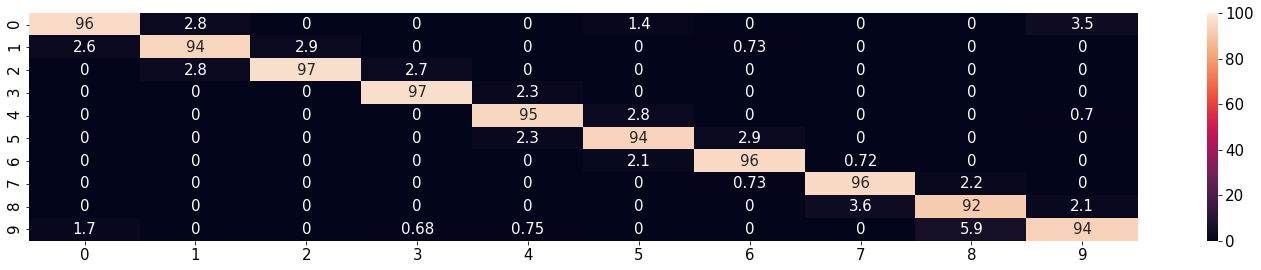

In [ ]:
#For nicer presentation, use a heatplot to show percentage correct for each class
import seaborn as sn

uniqueistim, countsistim = np.unique(y_testistim, return_counts=True) #Find out how often each class is present in y_test

countsmatrixistim = (np.repeat(countsistim,(n))) #Matrix of number of trials per condition
countsmatrixistim = np.reshape(countsmatrixistim,(n,n))

conf2istim = confistim / countsmatrixistim * 100 #Calculate percentage correct

axistim=sn.heatmap(conf2istim.T, 0,100,annot=True) #Plot the heatmap

In [80]:
#@title Split into running and no-running trials

datrun = dat["run"]
print(len(datrun))

#Get all trials where the mouse is moving (also excludes "very slow movements below 3 a.u.")
moving = datrun[datrun > 3]
print(len(moving))
datsresp = dat["sresp"]
datamoving = datsresp[:,datrun > 3]
istimmoving = dat["istim"][datrun > 3]

#Get all trials where the mouse is standing still
standing = datrun[datrun == 0]
print(len(standing))
datsresp = dat["sresp"]
datastanding = datsresp[:,datrun == 0]
istimstanding = dat["istim"][datrun == 0]


4598
1950
1399


In [125]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import sklearn.model_selection
import scipy.stats

train_size = 0.7 #use 70% of the data for training
rng = np.random.RandomState(0) #define random number generator

clfmoving = LDA() #define LDA
clfstanding = LDA() #define LDA


n = 10 #number of categories to distingush
spanistim = 2 * np.pi / n 
labelsmoving = istimmoving // spanistim # splits the data in n categories (whole numbers)
labelsstanding = istimstanding // spanistim # splits the data in n categories (whole numbers)
print(np.unique(labelsmoving, return_counts=True)) #show the labels
print(np.unique(labelsstanding, return_counts=True)) #show the labels

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([215, 176, 213, 202, 193, 195, 191, 188, 207, 170]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([107, 160, 155, 134, 121, 158, 163, 134, 121, 146]))


In [126]:
#Split the data into test and training sets
X_trainmoving, X_testmoving, y_trainmoving, y_testmoving = sklearn.model_selection.train_test_split(datamoving.T, labelsmoving, train_size=train_size, random_state=rng)
X_trainstanding, X_teststanding, y_trainstanding, y_teststanding = sklearn.model_selection.train_test_split(datastanding.T, labelsstanding, train_size=train_size, random_state=rng)

#Calculate z-score to make neuronal activity comparable
Z_trainmoving = scipy.stats.zscore(X_trainmoving, axis=1)
Z_testmoving = scipy.stats.zscore(X_testmoving, axis=1)
Z_trainstanding = scipy.stats.zscore(X_trainstanding, axis=1)
Z_teststanding = scipy.stats.zscore(X_teststanding, axis=1)

In [127]:
clfmoving.fit(Z_trainmoving, y_trainmoving)
clfstanding.fit(Z_trainstanding, y_trainstanding)

#LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
#  store_covariance=False, tol=0.0001) #used inputs for LDA()

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [128]:
y_predmoving = clfmoving.predict(Z_testmoving) #Predict classes for test set
y_predstanding = clfstanding.predict(Z_teststanding) #Predict classes for test set


In [129]:
#Plot predictions vs. real class as confusion matrix
from sklearn.metrics import confusion_matrix
confmoving = confusion_matrix(y_testmoving, y_predmoving)
print(confmoving)

confstanding = confusion_matrix(y_teststanding, y_predstanding)
print(confstanding)



[[65  0  0  0  0  3  0  0  0  1]
 [ 0 45  1  0  0  0  0  0  0  0]
 [ 0  0 74  1  0  0  0  0  0  0]
 [ 0  0  2 61  3  0  0  0  0  0]
 [ 1  0  0  0 47  6  0  0  0  0]
 [ 1  0  0  0  1 51  1  0  0  0]
 [ 0  0  0  0  0  2 49  1  0  0]
 [ 0  0  0  0  0  0  1 54  3  0]
 [ 0  0  0  0  0  0  0  1 63  1]
 [ 2  0  0  0  5  1  0  0  0 38]]
[[23  4  0  0  0  2  0  0  0  4]
 [ 2 42  0  0  0  0  0  0  0  0]
 [ 0  1 42  1  0  0  0  0  0  0]
 [ 0  0  0 42  1  0  0  0  0  0]
 [ 0  0  0  1 32  3  0  0  0  0]
 [ 0  0  0  0  4 47  1  0  0  0]
 [ 0  0  0  0  0  6 52  1  0  0]
 [ 0  0  0  0  0  0  1 31  2  0]
 [ 0  0  0  1  0  0  0  1 32  2]
 [ 0  0  0  0  0  0  0  0  0 39]]


In [130]:
#For nicer presentation, use a heatplot to show percentage correct for each class

uniquemoving, countsmoving = np.unique(y_testmoving, return_counts=True) #Find out how often each class is present in y_test

countsmatrixmoving = (np.repeat(countsmoving,(n))) #Matrix of number of trials per condition
countsmatrixmoving = np.reshape(countsmatrixmoving,(n,n))

conf2moving = confmoving / countsmatrixmoving * 100 #Calculate percentage correct




In [131]:
#For nicer presentation, use a heatplot to show percentage correct for each class
uniquestanding, countsstanding = np.unique(y_teststanding, return_counts=True) #Find out how often each class is present in y_test

countsmatrixstanding = (np.repeat(countsstanding,(n))) #Matrix of number of trials per condition
countsmatrixstanding = np.reshape(countsmatrixstanding,(n,n))

conf2standing = confstanding / countsmatrixstanding * 100 #Calculate percentage correct

(y_teststanding != y_predstanding).sum()/y_teststanding.sum() * 100

2.0042194092827006

Accuracy:  90.95238095238095


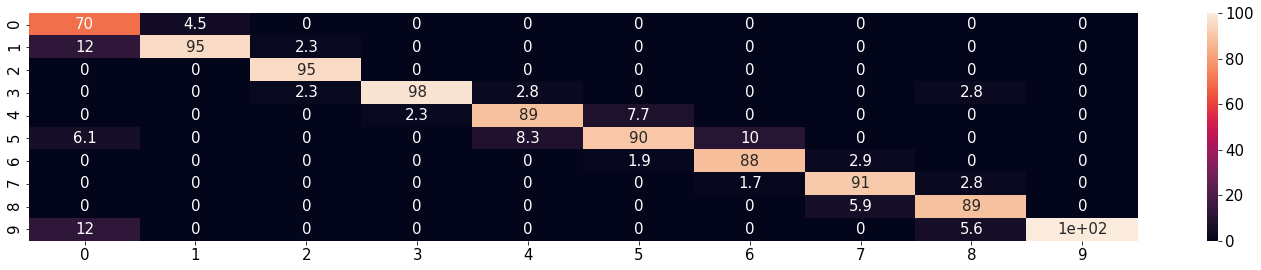

In [132]:
axstanding=sn.heatmap(conf2standing.T, 0,100,annot=True) #Plot the heatmap
print('Accuracy: ', (y_teststanding == y_predstanding).sum()/len(y_teststanding) * 100)

Accuracy:  93.5042735042735


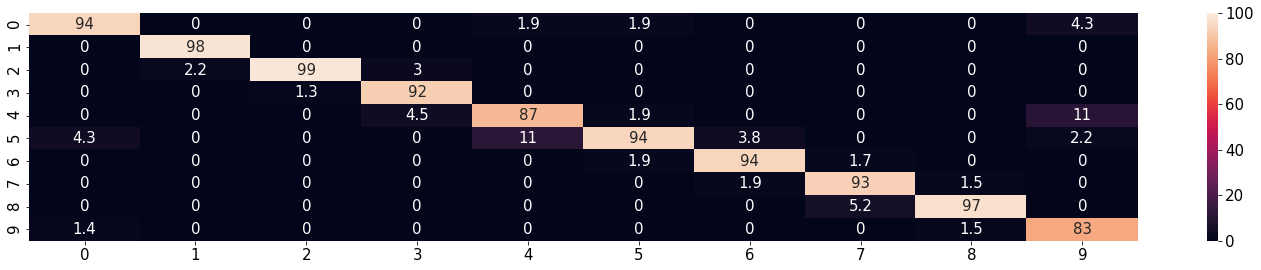

In [133]:
axmoving=sn.heatmap(conf2moving.T, 0,100,annot=True) #Plot the heatmap
print('Accuracy: ', (y_testmoving == y_predmoving).sum()/len(y_testmoving) * 100)

In [134]:
#@title Predicting across classifiers
y_predstanding = clfmoving.predict(Z_teststanding) #Predict classes for test set
y_predmoving = clfstanding.predict(Z_testmoving) #Predict classes for test set

#Plot predictions vs. real class as confusion matrix
from sklearn.metrics import confusion_matrix
confmoving = confusion_matrix(y_testmoving, y_predmoving)
print(confmoving)

confstanding = confusion_matrix(y_teststanding, y_predstanding)
print(confstanding)


[[59  2  0  0  0  4  0  0  0  4]
 [ 0 46  0  0  0  0  0  0  0  0]
 [ 0  9 65  1  0  0  0  0  0  0]
 [ 0  0  1 61  1  0  0  0  3  0]
 [ 0  0  0  1 48  3  0  0  0  2]
 [ 2  1  0  0  1 50  0  0  0  0]
 [ 1  0  0  0  0  4 47  0  0  0]
 [ 0  0  0  0  0  0  3 54  1  0]
 [ 0  0  0  1  0  0  0  2 60  2]
 [ 1  0  0  0  4  0  0  0  0 41]]
[[28  1  0  0  0  1  0  0  0  3]
 [ 1 38  4  0  0  0  1  0  0  0]
 [ 0  0 43  1  0  0  0  0  0  0]
 [ 0  0  0 42  1  0  0  0  0  0]
 [ 0  0  0  0 30  6  0  0  0  0]
 [ 0  0  0  0  1 44  7  0  0  0]
 [ 0  0  0  0  0  1 55  3  0  0]
 [ 0  0  0  0  0  0  0 31  3  0]
 [ 0  0  0  1  0  0  0  0 34  1]
 [ 0  0  0  0  0  0  0  0  2 37]]


In [135]:
#For nicer presentation, use a heatplot to show percentage correct for each class

uniquemoving, countsmoving = np.unique(y_testmoving, return_counts=True) #Find out how often each class is present in y_test

countsmatrixmoving = (np.repeat(countsmoving,(n))) #Matrix of number of trials per condition
countsmatrixmoving = np.reshape(countsmatrixmoving,(n,n))

conf2moving = confmoving / countsmatrixmoving * 100 #Calculate percentage correct

#For nicer presentation, use a heatplot to show percentage correct for each class
uniquestanding, countsstanding = np.unique(y_teststanding, return_counts=True) #Find out how often each class is present in y_test

countsmatrixstanding = (np.repeat(countsstanding,(n))) #Matrix of number of trials per condition
countsmatrixstanding = np.reshape(countsmatrixstanding,(n,n))

conf2standing = confstanding / countsmatrixstanding * 100 #Calculate percentage correct


Accuracy:  90.95238095238095


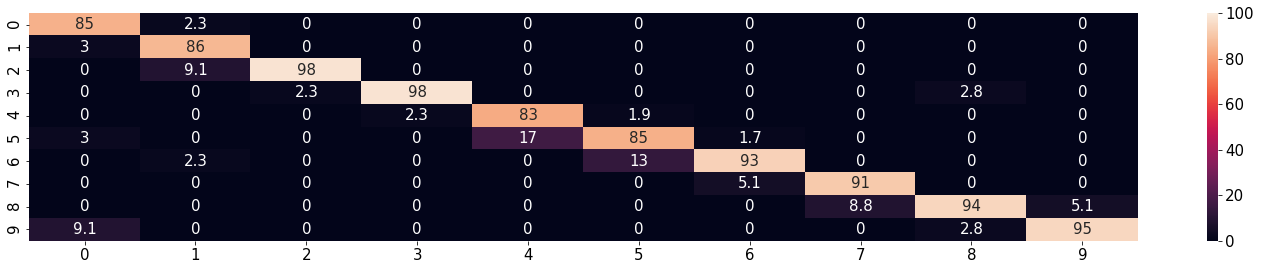

In [136]:
#Standing data predicted by the classifier that was trained on moving data
axstanding=sn.heatmap(conf2standing.T, 0,100,annot=True) #Plot the heatmap

print('Accuracy: ', (y_teststanding == y_predstanding).sum()/len(y_teststanding) * 100)

Accuracy:  90.76923076923077


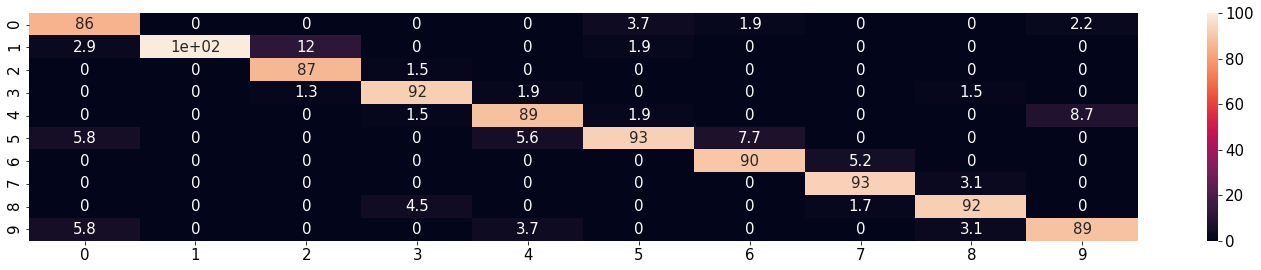

In [137]:
#Moving data predicted by the classifier that was trained on standing data

axmoving=sn.heatmap(conf2moving.T, 0,100,annot=True) #Plot the heatmap
print('Accuracy: ', (y_testmoving == y_predmoving).sum()/len(y_testmoving) * 100)

In [138]:
print(dat['run'].shape)
print(np.min(dat['run']))
print(np.max(dat['run']))

(4598,)
0.0
80.61597


In [7]:
#@title Try to classify running speed from neuronal acitivy in V1
#(This is basically the same as before just with run instead of istim)

import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import sklearn.model_selection
import scipy.stats

train_size = 0.7 #use 70% of the data for training
rng = np.random.RandomState(0) #define random number generator

clf = LDA() #define LDA

n = 10 #number of categories to distingush
spanrun = 80.61597 / n 
labelsrun = dat["run"] // spanrun # splits the data in n categories (whole numbers)
sresp = dat['sresp'].T #read out the neuronal activity for each neuron

print(np.unique(labelsrun)) #show the labels

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [8]:
#Split the data into test and training sets
X_trainrun, X_testrun, y_trainrun, y_testrun = sklearn.model_selection.train_test_split(dat['sresp'].T, labelsrun, train_size=train_size, random_state=rng)
#Calculate z-score to make neuronal activity comparable
Z_trainrun = scipy.stats.zscore(X_trainrun, axis=1)
Z_testrun = scipy.stats.zscore(X_testrun, axis=1)

In [ ]:
clf.fit(Z_trainrun, y_trainrun)
#LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
#  store_covariance=False, tol=0.0001) #used inputs for LDA()

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
y_predrun = clf.predict(Z_testrun) #Predict classes for test set

#plt.scatter(y_test, y_pred) #Scatter plot between real and predicted input

In [ ]:
#Plot predictions vs. real class as confusion matrix
from sklearn.metrics import confusion_matrix
confrun = confusion_matrix(y_testrun, y_predrun)
print(confrun.T)

[[869  53   7   0   0   0   0   0   0   0]
 [ 25  44  20  13   3   3   0   0   0   0]
 [  2  10  11  10   2   2   0   0   0   0]
 [  0   6   9  12   7   6   4   1   0   0]
 [  2   3   4  11   9   5  10   4   0   0]
 [  0   0   2   7  19  30  25  13   2   0]
 [  0   0   1   5  14  18  28  12  10   1]
 [  1   0   0   2   2   4   9   1   0   3]
 [  0   0   0   1   0   2   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


[899 116  54  61  56  70  77  31  12   4]


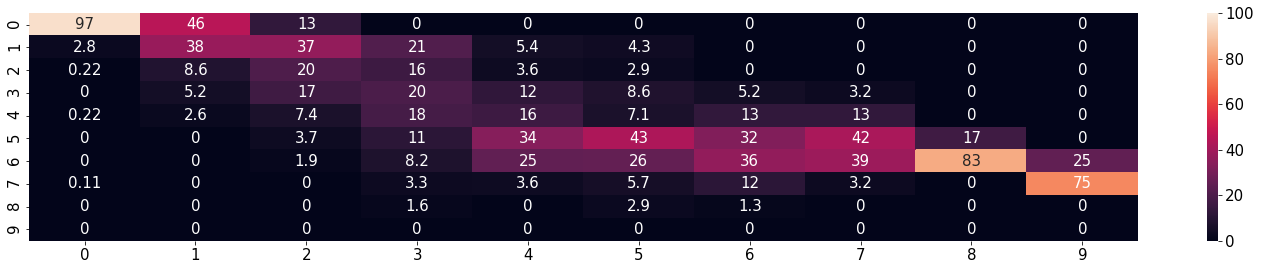

In [ ]:
#For nicer presentation, use a heatplot to show percentage correct for each class
import seaborn as sn

uniquerun, countsrun = np.unique(y_testrun, return_counts=True) #Find out how often each class is present in y_test
print(countsrun)

countsmatrixrun = (np.repeat(countsrun,(n))) #Matrix of number of trials per condition
countsmatrixrun = np.reshape(countsmatrixrun,(n,n))

conf2run = confrun / countsmatrixrun * 100 #Calculate percentage correct

ax=sn.heatmap(conf2run.T, 0,100,annot=True) #Plot the heatmap

In [ ]:
# The top plot might be biased towards velocity of zero a.u. (1399 trials alone!)
#@title Trying to get a more even distribution of trials without zeros

In [18]:
uniquerun, countsrun = np.unique(dat['run'], return_counts=True) #Find out how often each class is present in y_test
print(uniquerun)
print(countsrun)
print(len(countsrun))
print(np.sort((countsrun[countsrun<1399])))

[0.0000000e+00 8.0301356e-07 1.3383559e-06 ... 7.5989861e+01 7.7829803e+01
 8.0615967e+01]
[1399    1    1 ...    1    1    1]
3198
[1 1 1 ... 1 2 2]


4598
3199


In [48]:
#Try to classify running speed from neuronal acitivy in V1 -> Without zero velocity!
#(This is basically the same as before just with run instead of istim)

datrun = dat["run"]
print(len(datrun))

alwaysmoving = datrun[datrun > 3]
print(len(alwaysmoving))
datsresp = dat["sresp"]
dataalwaysmoving = datsresp[:,datrun > 3]

4598
1950


In [54]:
#Try to classify running speed from neuronal acitivy in V1 -> Without zero velocity!
#(This is basically the same as before just with run instead of istim)

import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import sklearn.model_selection
import scipy.stats

train_size = 0.7 #use 70% of the data for training
rng = np.random.RandomState(0) #define random number generator

clf = LDA() #define LDA

n = 10 #number of categories to distingush
spanrun = 80.61597 / n 
labelsrun = alwaysmoving // spanrun # splits the data in n categories (whole numbers)
sresp = dataalwaysmoving.T #read out the neuronal activity for each neuron

print(np.unique(labelsrun)) #show the labels



[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [55]:
#Show number of entries for each class
uniquerun, countsrun = np.unique(labelsrun, return_counts=True) #Find out how often each class is present in y_test
print(countsrun)



[363 375 202 178 194 247 236 106  42   7]


In [56]:
#Split the data into test and training sets
X_trainrun, X_testrun, y_trainrun, y_testrun = sklearn.model_selection.train_test_split(sresp, labelsrun, train_size=train_size, random_state=rng)
#Calculate z-score to make neuronal activity comparable
Z_trainrun = scipy.stats.zscore(X_trainrun, axis=1)
Z_testrun = scipy.stats.zscore(X_testrun, axis=1)

In [57]:
clf.fit(Z_trainrun, y_trainrun)
#LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
#  store_covariance=False, tol=0.0001) #used inputs for LDA()

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [59]:
y_predrun = clf.predict(Z_testrun) #Predict classes for test set

#plt.scatter(y_test, y_pred) #Scatter plot between real and predicted input

In [60]:
#Plot predictions vs. real class as confusion matrix
from sklearn.metrics import confusion_matrix
confrun = confusion_matrix(y_testrun, y_predrun)
print(confrun.T)

[[69 37  4  2  0  1  0  0  0  0]
 [41 51 27 10  5  2  0  0  0  0]
 [ 2 10  8  8  3  3  2  0  1  0]
 [ 1 10  8 10  5  9  3  0  0  0]
 [ 1  1  2  4 16 17  8  3  1  2]
 [ 0  1  0  9 19 29 16  5  0  0]
 [ 0  0  3  7 12 23 22 14  3  0]
 [ 0  0  0  0  2  8 10  4  3  1]
 [ 0  0  0  1  0  1  3  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


[114 110  52  51  62  93  64  27   9   3]


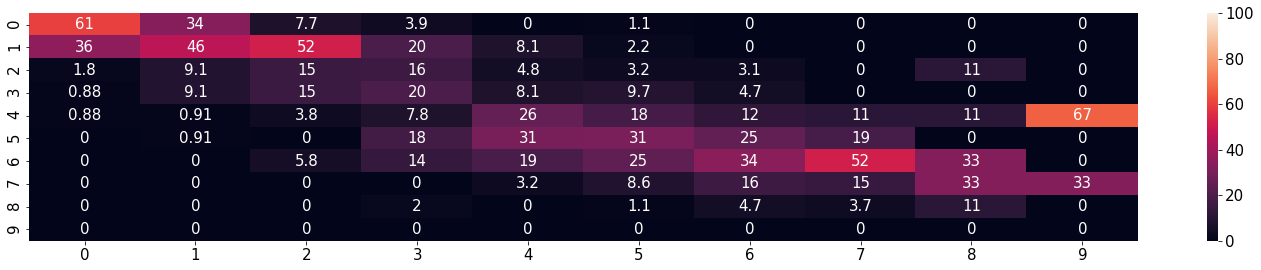

In [61]:
#For nicer presentation, use a heatplot to show percentage correct for each class
import seaborn as sn

uniquerun, countsrun = np.unique(y_testrun, return_counts=True) #Find out how often each class is present in y_test
print(countsrun)

countsmatrixrun = (np.repeat(countsrun,(n))) #Matrix of number of trials per condition
countsmatrixrun = np.reshape(countsmatrixrun,(n,n))

conf2run = confrun / countsmatrixrun * 100 #Calculate percentage correct

ax=sn.heatmap(conf2run.T, 0,100,annot=True) #Plot the heatmap

In [143]:
#@title Gaussian Naive Bayes classifier for running speed

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(Z_trainrun, y_trainrun).predict(Z_testrun)

In [74]:
from sklearn.metrics import confusion_matrix
confrun = confusion_matrix(y_testrun, y_pred)
print(confrun.T)

[[48 29  4  2  0  1  0  0  1  0]
 [48 46 25 11 13  6  7  2  0  0]
 [10 12  6  8  5  6  2  0  1  0]
 [ 4 11  7  9  7 11  8  2  2  0]
 [ 1  8  4  5  8 16  7  7  1  2]
 [ 1  1  2  9 13 22 14  4  1  0]
 [ 2  2  3  6 14 22 19 12  1  0]
 [ 0  1  1  1  2  8  7  0  0  1]
 [ 0  0  0  0  0  1  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


[114 110  52  51  62  93  64  27   9   3]


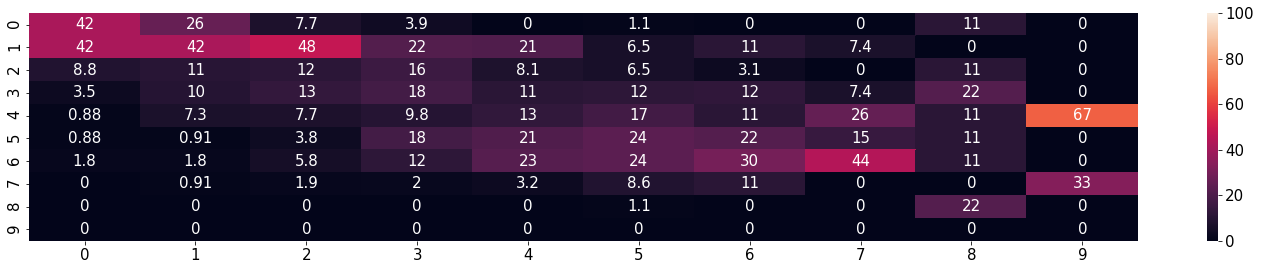

In [75]:
#For nicer presentation, use a heatplot to show percentage correct for each class
import seaborn as sn

uniquerun, countsrun = np.unique(y_testrun, return_counts=True) #Find out how often each class is present in y_test
print(countsrun)

countsmatrixrun = (np.repeat(countsrun,(n))) #Matrix of number of trials per condition
countsmatrixrun = np.reshape(countsmatrixrun,(n,n))

conf2run = confrun / countsmatrixrun * 100 #Calculate percentage correct

ax=sn.heatmap(conf2run.T, 0,100,annot=True) #Plot the heatmap